# Variational Autoencoder
Notebook to experiment with an variational autoencoder using Keras with Tensorflow backend and MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input,Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using TensorFlow backend.


### Hyperparameters

In [2]:
batch_size = 100
original_dimension = 784
latent_dimension = 2
intermediate_dimension = 256
epochs = 75
epsilon_std = 1.0


### Encoder

Takes the inputs "x" and converts them to a latent distribution parameters. 

Its architecture is: intput to hidden layer, hidden layer to 2 latent distribution parameters vectors(represented as fully conected layers). The 2 vectors representing the latent distribution parameters are used to calculate a "z" representation of the input using a "sampling" function.

The decoder will take "z" as input, and will convert it to the original input "x"

In [3]:
x_layer = Input(batch_shape=(batch_size,original_dimension))
encoder_intermediate_layer = Dense(intermediate_dimension,activation='relu')(x_layer)

latent_mean = Dense(latent_dimension)(encoder_intermediate_layer)
latent_log_var = Dense(latent_dimension)(encoder_intermediate_layer)
print(latent_mean)
print(latent_log_var)

Tensor("dense_2/BiasAdd:0", shape=(100, 2), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(100, 2), dtype=float32)


In [4]:
def sampling(args):
    z_mean,z_log_var = args
    epsilon = K.random_normal(shape = (batch_size,latent_dimension),mean=0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([latent_mean, latent_log_var])#([latent_mean,latent_log_var])
print(z)

Tensor("lambda_1/add:0", shape=(100, 2), dtype=float32)


### Decoder

Once we have a tensor "z" sampled from the distribution given by the 2 latent parameters , we can feed it to the decoder, the decoder will map the "z" points back to the original data "x".

Its architecture is: "z" to hidden layer with 'relu' activation , hidden layer to output layer with 'sigmoid' activation.

The decoder output layer will output a 'x' very similar to the input

In [5]:
decoder_intermediate_layer = Dense(intermediate_dimension,activation='relu')
decoder_output = Dense(original_dimension,activation='sigmoid')

decoder_intermediate_values = decoder_intermediate_layer(z)
decoder_output_values = decoder_output(decoder_intermediate_values)

print(decoder_output_values)

Tensor("dense_5/Sigmoid:0", shape=(100, 784), dtype=float32)


### Loss and optimization objective
The loss is formed by 2 sub-loss terms which we cant to minimize, the minimization will be done using gradient descent or a variation of it. The 2 different losses are:
* Generation or content loss: measures how different the generated outputs are with respect to the inputs, we want the output to be not different from the input(cross entropy between inputs and outputs)
* KL-divergence loss(also called regularizer): since we are using a probability distribution parameters to genereate the data intermediate representation , we want similar points in the latent distribution to correspond to similar inputs, this loss measures how the probability distribution parameters generate similar representation to similar inputs. This means that similar inputs , will have similar "z" values, or else the loss will be high.

Total loss is the sum of this 2 loss terms.

In [6]:
def total_loss(x,x_decoded):
    z_mean = latent_mean
    z_log_var = latent_log_var
    # x = the input to the autoencoder
    # x_decoded the output of the autoencoder taken from the decoder after it decodes "z"
    # z_mean : the vector of means of the z distributuion
    # z_log_var : the vector of stds from the z distribution
    content_loss = original_dimension * objectives.binary_crossentropy(x,x_decoded)
    kl_divergence_loss = -0.5 * K.sum(1+ z_log_var - K.square(z_mean)-K.exp(z_log_var),axis=-1)
    
    return content_loss+kl_divergence_loss
    
variational_autoencoder = Model(x_layer,decoder_output_values)
variational_autoencoder.compile(optimizer = 'rmsprop',loss=total_loss)

### Prepare data
Since the output of the autoencoder is the same as its input, the "y" of the dataset is not used

In [7]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

# Normalize inputs to be between  0 and 1 instead of 0 and 255
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Train autoencoder

In [8]:
variational_autoencoder.fit(x_train,x_train,
                        shuffle=True,
                           epochs=epochs,
                           batch_size=batch_size,
                           validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/75
60000/60000 [==============================] - 1s - loss: 190.4324 - val_loss: 172.2307
Epoch 2/75
60000/60000 [==============================] - 1s - loss: 169.8474 - val_loss: 167.7788
Epoch 3/75
60000/60000 [==============================] - 1s - loss: 166.3843 - val_loss: 165.5432
Epoch 4/75
60000/60000 [==============================] - 1s - loss: 164.3153 - val_loss: 163.6188
Epoch 5/75
60000/60000 [==============================] - 1s - loss: 162.8906 - val_loss: 162.4722
Epoch 6/75
60000/60000 [==============================] - 1s - loss: 161.7257 - val_loss: 161.3996
Epoch 7/75
60000/60000 [==============================] - 1s - loss: 160.6993 - val_loss: 160.5506
Epoch 8/75
60000/60000 [==============================] - 1s - loss: 159.7778 - val_loss: 159.5815
Epoch 9/75
60000/60000 [==============================] - 1s - loss: 158.9227 - val_loss: 158.8121
Epoch 10/75
60000/60000 [==============================] - 

### Visualizations 
#### Cluster neighborhood of latent representation of classes:

Every cluster(with a specific color) is a digit type clusters that are close are clusters that share similar representation in the latent space(similar z value) 

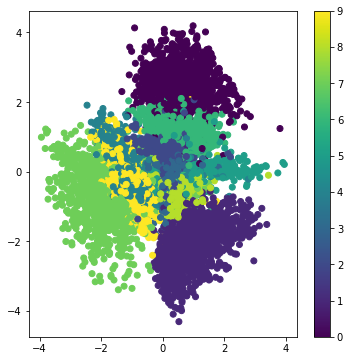

In [9]:
encoder = Model(x_layer,latent_mean)

x_test_encoded = encoder.predict(x_test,batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

### Generate new digit images

The variational autoencoder is a generative algorithm, we will use it to generate new digits by sampling points from the learned latent distribution and generating the corresponding images for every sample.

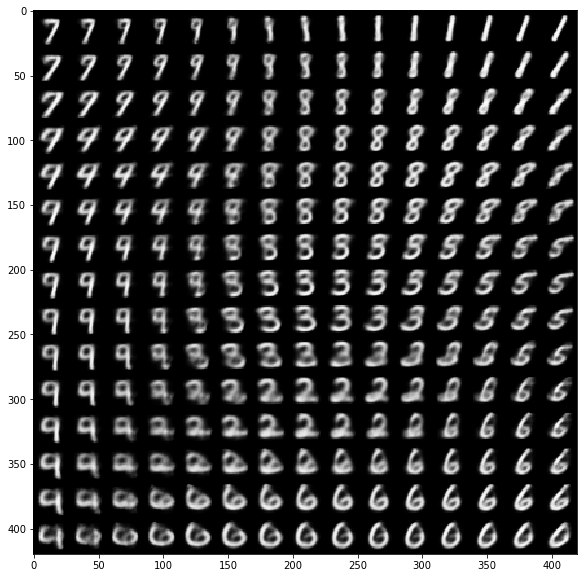

In [12]:
decoder_input = Input(shape=(latent_dimension,))
h_decoded= decoder_intermediate_layer(decoder_input)
x_decoded_output = decoder_output(h_decoded)
generator = Model(decoder_input,x_decoded_output)

grid_size = 15
digit_size = 28
figure = np.zeros((digit_size * grid_size, digit_size * grid_size))

grid_x = norm.ppf(np.linspace(0.05,0.95 , grid_size))
grid_y = norm.ppf(np.linspace(0.05, 0.95 ,grid_size))

for i,yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi,yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()